In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import yfinance as yf
import pandas as pd
import numpy as np

import utils as lbl_utils
import ct_two_state as ct2
import ct_three_state as ct3
import fixed_time_horizon as fth
import oracle
import triple_barrier as tb

In [2]:
ticker_symbol = 'GC=F'
start_date = '2000-01-01'
end_date = '2023-11-01'

prices = yf.download(ticker_symbol, start_date, end_date, interval='1d')['Close']
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
(5813,)
Date
2000-08-30    273.899994
2000-08-31    278.299988
2000-09-01    277.000000
2000-09-05    275.799988
2000-09-06    274.200012
Name: Close, dtype: float64


In [3]:
# trans_fee = 0.0004
# #-------------------------------------------
# tau = 0.0004
# labels = ct2.binary_trend_labels(prices, tau=tau)
# lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tau = 0.0004
# window = 3
# labels = ct3.get_labels(prices, tau=tau, w=window)
# lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tau = 0.0002
# H = 1
# labels = fth.binary_trend_labels(prices, tau=tau, H=H)
# lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# fee = 0.0004
# labels = oracle.binary_trend_labels(prices, fee=fee)
# lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# labels = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1)
# lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
# print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
# #-------------------------------------------
# # Meta labeling
# #side = labels
# #side[side == 0] = -1
# #side = side.shift(1).fillna(method='bfill')
# #labels_2 = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1, side=side)
# # iterate through labels_2 and if it has value 1 set ti to value from labels on same index, otherwise set to 0
# #labels_2 = pd.Series((labels[i] if labels_2[i] == 1 else 0 for i in labels_2.index), index=labels_2.index)
# #lbl_utils.plot_labels('TB Meta Labeling; {}'.format(ticker_symbol), prices, labels_2)


In [3]:
fee = 0.0004
num_threads = 16
file_store = './best_params_all_data.txt'
# #-------------------------------------------
# # CT2
# print('Optimizing CT2')
# param_grid = [
#     np.arange(0, 0.003, 0.00002).tolist() # tau
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct2.binary_trend_labels, prices=prices
#                                         , param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('CT2; fee={}; tau={}\n'.format(fee, best_params[0]))
# # CT3
# print('Optimizing CT3')
# param_grid = [
#     np.arange(0, 0.003, 0.00002).tolist(),  # tau
#     np.arange(0, 20, 1).tolist()            # window
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=ct3.binary_trend_labels, prices=prices, 
#                                               param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('CT3; fee={}; tau={}; window={}\n'.format(fee, best_params[0], best_params[1]))

# # FTH
# print('Optimizing FTH')
# param_grid = [
#     np.arange(0, 0.0003, 0.000001).tolist(),  # tau
#     np.arange(1, 20, 1).tolist()            # H
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=fth.binary_trend_labels, prices=prices,
#                                               param_grid=param_grid, fee=fee, num_threads=num_threads)
# with open(file_store, 'a') as f:
#     f.write('FTH; fee={}; tau={}; H={}\n'.format(fee, best_params[0], best_params[1]))

# Triple Barrier
print('Optimizing Triple Barrier')
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(days=30))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
param_grid = [
    [tEvents],                          # tEvents
    np.arange(0, 4.2, 0.1).tolist(),  #pt
    np.arange(0, 4.2, 0.1).tolist(),  #sl
    [minuteVol],                        # volatility
    [0],                                # minRet
    [t1],                               # t1
]
best_params = lbl_utils.optimize_label_params(binary_trend_labels=tb.binary_trend_labels, prices=prices,
                                              param_grid=param_grid, fee=fee, num_threads=num_threads)
with open(file_store, 'a') as f:
    f.write('TB; fee={}; pt={}; sl={}\n'.format(fee, best_params[1], best_params[2]))

Optimizing Triple Barrier
Number of parameter combinations: 1764
Number of threads: 16, Number of parameter combinations per thread: 111


Optimizing:   0%|                                                          | 0/1764 [00:00<?, ?it/s]

Optimizing: 100%|█████████████████████████████████████████████| 1764/1764 [1:51:36<00:00,  3.80s/it]


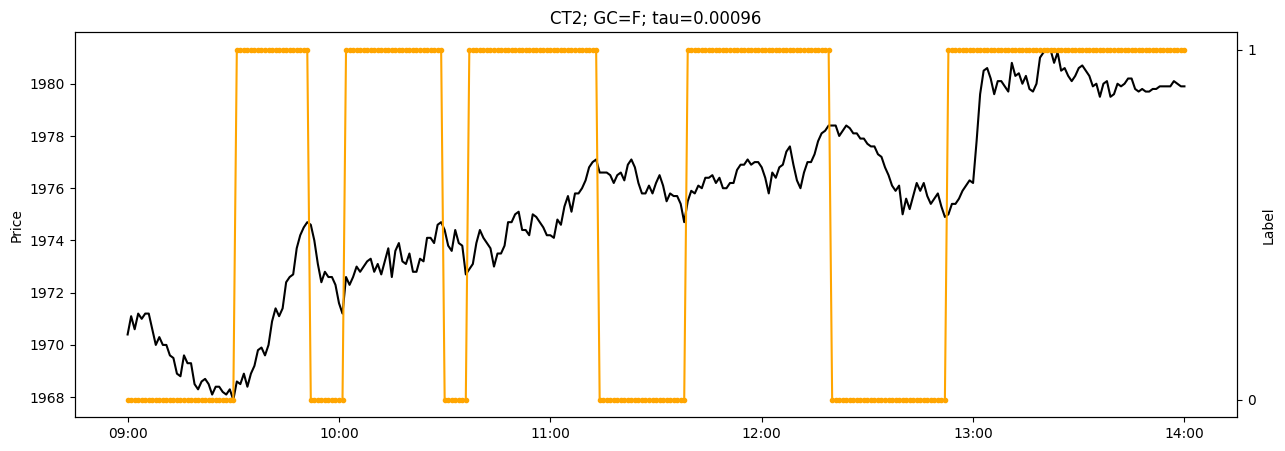

comulative return: 0.8262831342705557%


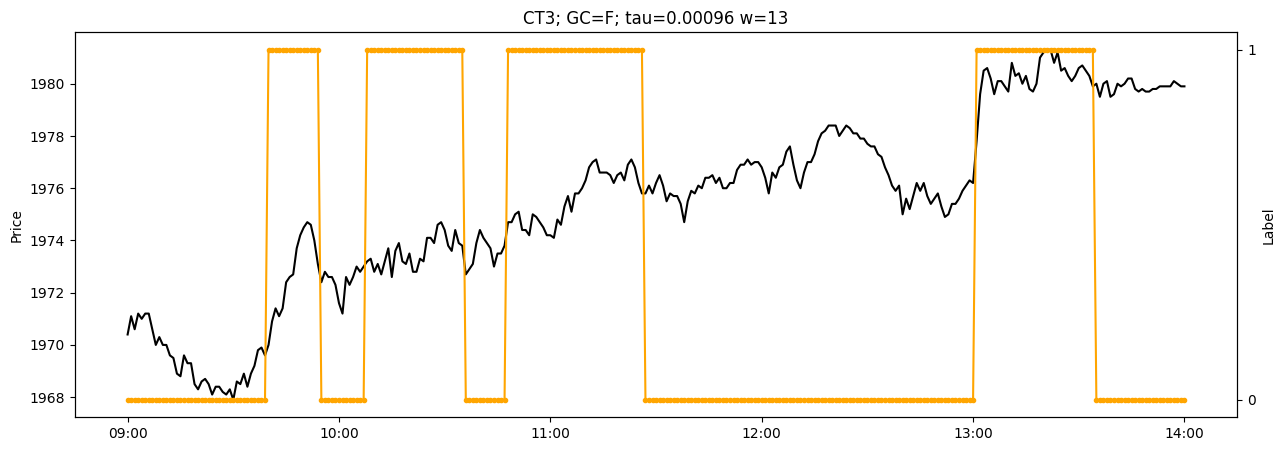

comulative return: 0.18960590544143674%


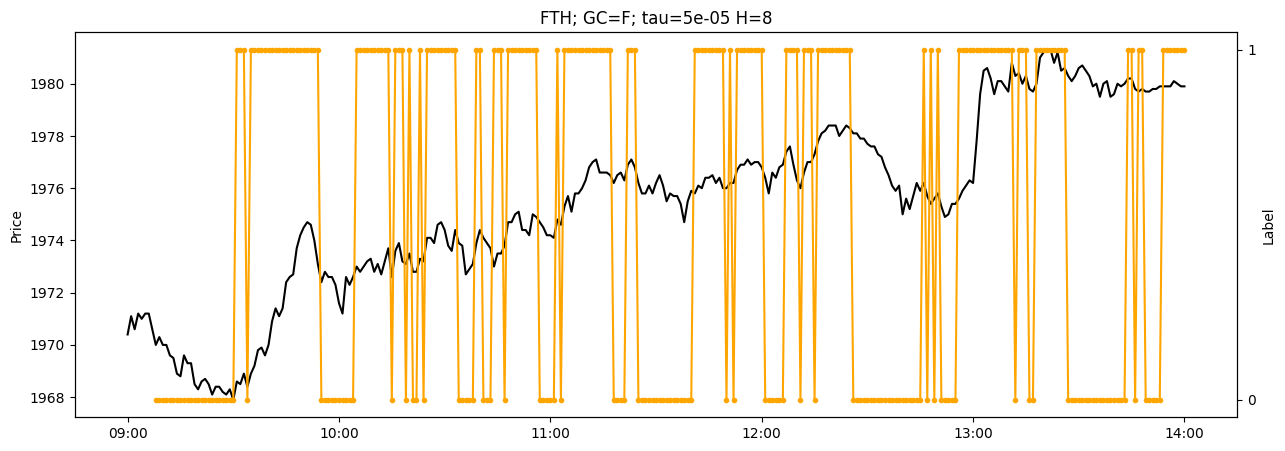

comulative return: -0.4458045365594021%


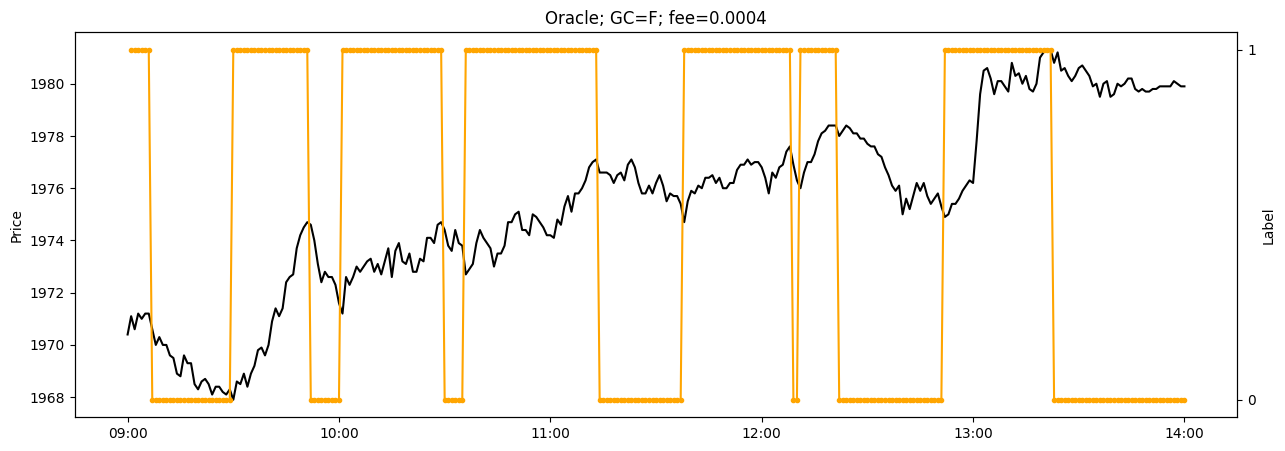

comulative return: 1.067497502948167%


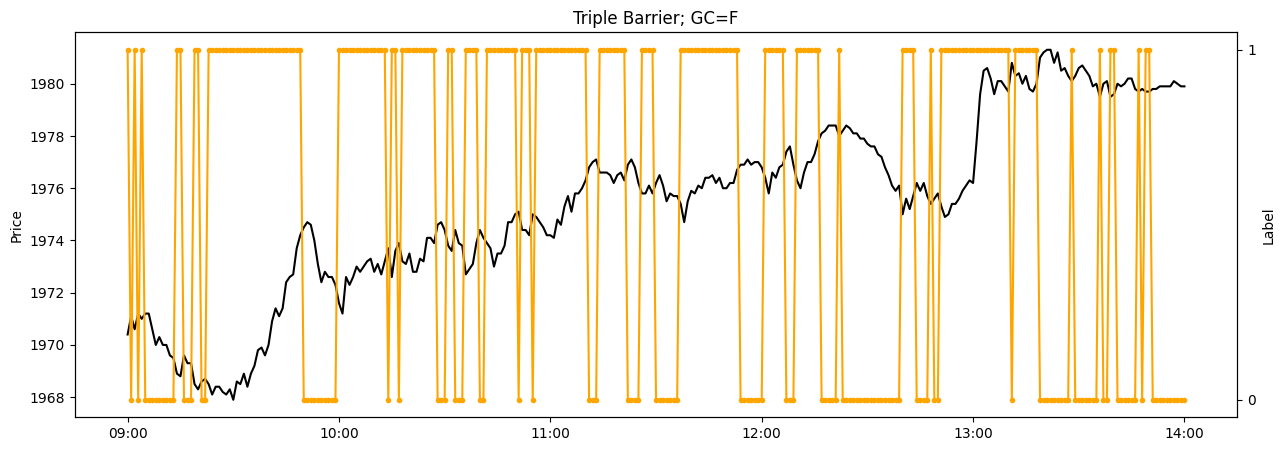

comulative return: -0.1522134764628036%


In [3]:
trans_fee = 0.0004
#-------------------------------------------
tau = 0.00096
labels = ct2.binary_trend_labels(prices, tau=tau)
lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.00096
window = 13
labels = ct3.binary_trend_labels(prices, tau=tau, w=window)
lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tau = 0.00005
H = 8
labels = fth.binary_trend_labels(prices, tau=tau, H=H)
lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
fee = 0.0004
labels = oracle.binary_trend_labels(prices, fee=fee)
lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))
#-------------------------------------------
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
labels = tb.binary_trend_labels(prices, tEvents, pt=0.6, sl=1.3, volatility=minuteVol, minRet=0, t1=t1)
lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))

In [4]:
# import pickle

# with open('labels_dict.pkl', 'rb') as file:
#         labels_dict = pickle.load(file)
# old_tp_labels = labels_dict['triple_barrier']

# ticker_symbol = 'GC=F'
# start_date = '2000-01-01'
# end_date = '2023-11-01'

# prices = yf.download(ticker_symbol, start_date, end_date, interval='1d')['Close']
# prices.index = prices.index.tz_localize(None)

[*********************100%%**********************]  1 of 1 completed


In [1]:
# # optimize
# trans_fee = 0.0004
# num_threads = 16
# #-------------------------------------------
# tEvents = prices.index
# t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
# t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
# minuteVol = tb.getMinuteVol(prices, span=100)
# minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
# param_grid = [
#     [tEvents],                          # tEvents
#     np.arange(0, 4.2, 0.1).tolist(),  #pt
#     np.arange(0, 4.2, 0.1).tolist(),  #sl
#     [minuteVol],                        # volatility
#     [0],                                # minRet
#     [t1],                               # t1
# ]
# best_params = lbl_utils.optimize_label_params(binary_trend_labels=tb.binary_trend_labels, prices=prices,
#                                               param_grid=param_grid, fee=trans_fee, num_threads=num_threads)

NameError: name 'prices' is not defined

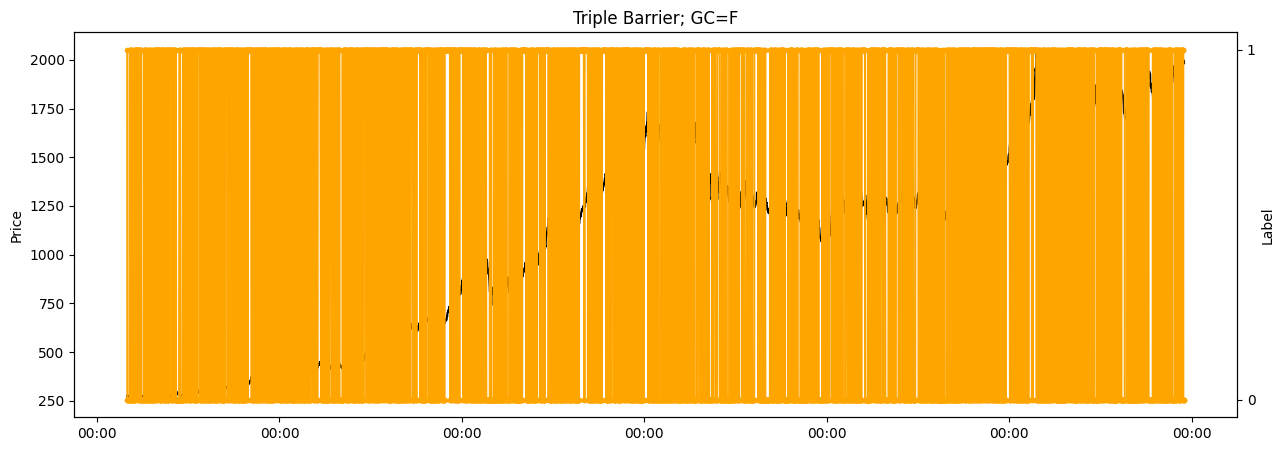

NameError: name 'trans_fee' is not defined

In [4]:
# lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, old_tp_labels)
# #-------------------------------------------
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(days=30))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)
minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')
labels = tb.binary_trend_labels(prices, tEvents, pt=1, sl=0.7, volatility=minuteVol, minRet=0, t1=t1)
lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)
print('comulative return: {}%'.format(lbl_utils.compute_return(prices, labels, trans_fee)*100))

In [9]:
# print(best_params[1], best_params[2])

0.0 0.0


In [12]:
# print(labels.value_counts())

bin
1.0    3787
0.0    2026
Name: count, dtype: int64
